# Purpose

The purpose of this notebooks is:
1. Ingest 10m Movielens Dataset into pandas dataframes
2. Explore the datasets
3. Identify requirements for processing the data for building factorization machine models

Note: Data was downloaded from: https://grouplens.org/datasets/movielens/10m/.

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import scipy.sparse as scs

sns.set_context('notebook', font_scale=1.4)

# Explore Interactions Dataset

Questions:
1. What is the distribution of Ratings
2. If we were to convert ratings into an implicit model, where should we threshold data between like and dislike?
3. Let's investigate number of movies watched by each user, and similarly how many times each movie has been watched
4. Calculate the sparsity of user item interactions.

In [3]:
interactions = pd.read_csv('../data/raw/ratings.dat',
                           sep='::', engine='python',
                           header=None,
                           names=['uid', 'iid', 'rating', 'timestamp'],
                           usecols=['uid', 'iid', 'rating']
                          )
display(interactions.sample(5))

,uid,iid,rating
3582056,25723,2081,4.5
7991381,57313,2414,3.5
4190506,29979,1924,5.0
6557686,46886,3067,3.0
9831551,70398,50068,5.0


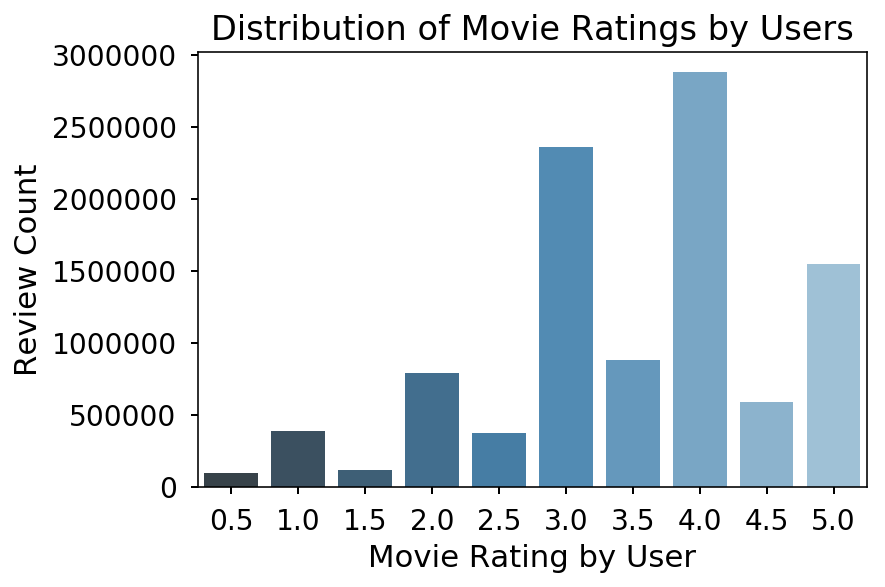

In [6]:
data = (
    interactions['rating']
    .value_counts()
    .reset_index()
)
sns.barplot(x='index', y='rating', data=data, palette='Blues_d');
plt.ylabel('Review Count')
plt.xlabel('Movie Rating by User')
plt.title('Distribution of Movie Ratings by Users')
plt.show()

Distribution of Ratings shows very few below 3.0. Because of this, I will relable all ratings >= 4.0 as being a positive preference.

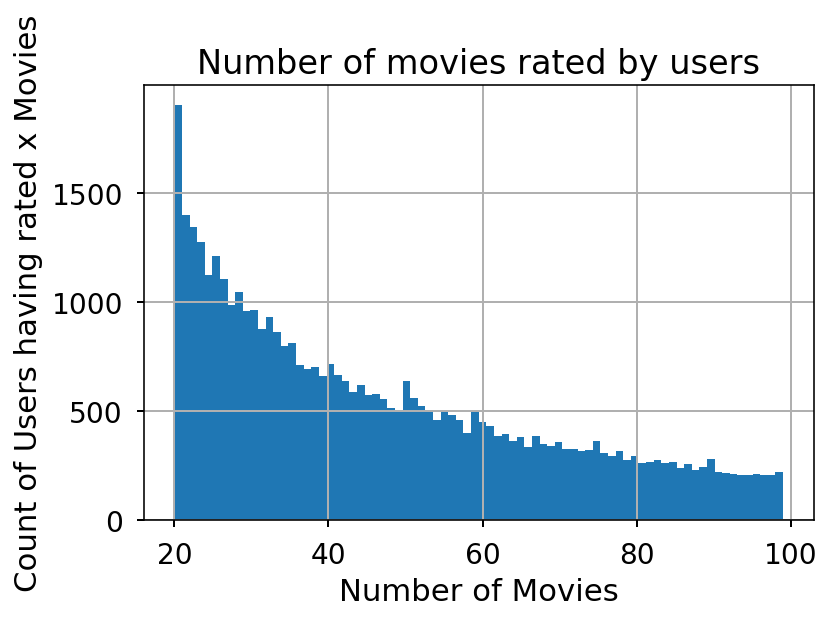

In [15]:
data = interactions.groupby('uid')['rating'].count()
data = data[data < 100]
data.hist(bins=80)
plt.title('Number of movies rated by users')
plt.xlabel('Number of Movies')
plt.ylabel('Count of Users having rated x Movies')
plt.show()

All users have rated at least 20 movies. The distribution shows a slow exponential decay in the number of movies rated by users.

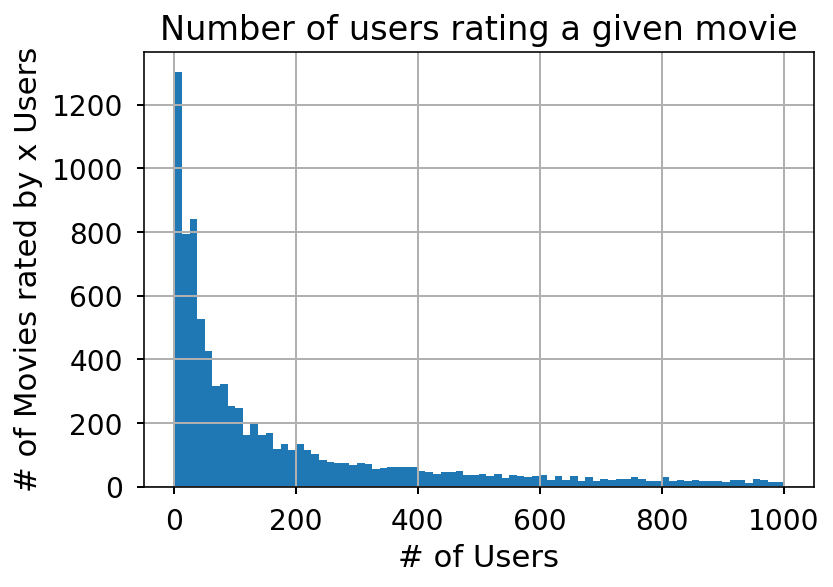

In [10]:
data = interactions.groupby('iid')['rating'].count()
data = data[data < 1000]
data.hist(bins=80)
plt.title('Number of users rating a given movie')
plt.xlabel('# of Users')
plt.ylabel('# of Movies rated by x Users')
plt.show()

Unsurprisingly, there are many movies rated only a couple times, a fewer movies rated many times. The distribution of movie rating count appears exponential.

## Sparsity Analysis

Prior to building any recommender, it is important to quantify sparsity of the user item utility matrix. Typically, collaborative filtering demonstrates improvements over popularity when the sparsity < 99.5%

In [31]:
implicit_interactions = interactions.loc[interactions['rating'] >= 4, ['uid', 'iid']]
# verify we do not have duplicate ratings for a user - movie pair
assert implicit_interactions.duplicated().sum() == 0

# create uid to indx mapping
uniq_uids = implicit_interactions['uid'].unique()
uid_to_idx = dict(zip(uniq_uids, np.arange(len(uniq_uids))))

# create iid to indx mapping
uniq_iids = implicit_interactions['iid'].unique()
iid_to_idx = dict(zip(uniq_iids, np.arange(len(uniq_iids))))

# generate sparse matrix
row = implicit_interactions['uid'].map(uid_to_idx)
col = implicit_interactions['iid'].map(iid_to_idx)
assert len(row) == len(col)
data = np.ones(len(row))
shape = (len(uniq_uids), len(uniq_iids))

csr = scs.coo_matrix((data, (row, col)), shape=shape).tocsr()

In [42]:
def calculate_sparsity(sparse):
    return 1.0 - sparse.nnz / (sparse.shape[0] * sparse.shape[1])

print('Utility Matrix Sparsity: {:0.2%}'.format(calculate_sparsity(csr)))

Utility Matrix Sparsity: 99.30%


The Utility matrix has a sparsity < 99.5% indicating collaborative filtering can likely yield improved recommendations over a popularity based model. Note, that if this was not the case, we still might see improved results with collaborative filtering as there are many movies rated only one or two times. These movies tend to increase sparsity but may not necessarily hurt our ability to generalize user and item preferences.

# Takeways

An appropriate way to treat this data is to convert ratings 4.0 or higher into likes. We will drop all data with ratings < 4.0 and build implicit recommenders which have demonstrated superior results for ranking metrics. Sparsity analysis demonstrates we should expect improved results using collaborative filtering based models.